# ENTREGA DEEP LEARNING

## Integrantes:

 + Jorge Peralta Fernández-Revuelta Lechuga

 + Alberto García Martín

 + Ignacio Urretavizcaya Tato

 + Juan López Segura

## Primer paso (Sólo si se desean entrenar modelos en W&B):

 + En terminal, habiendo activado el entorno: wandb login

 + Pegar la API KEY: a8be9b6fcd7b2715da8018421e06657d1e080477

In [4]:
from cnn import CNN
from local_functs import show_images_grid
import torchvision
from cnn import load_model_weights
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

import wandb
import random

## 1. Creación del Modelo de Clase

### Carga de Modelo y Datos

Se comienza con la carga de los modelos preentrenados de pytorch, para posteriormente utilizarlos en la práctica.

In [5]:
# Pytorch has many pre-trained models that can be used for transfer learning
classification_models = torchvision.models.list_models(module=torchvision.models)

Comenzamos utilizando el modelo de clase, con los datos de entrenamiento y validación proporcionados.

In [6]:
# Load data and model 
from data_loader import num_classes, train_loader, valid_loader
model = CNN(torchvision.models.resnet50(weights='DEFAULT'), num_classes)

### Visualización de Muestra

Posteriormente, se presentan algunas imágenes del conjunto para conocer mejor el conjunto de datos.

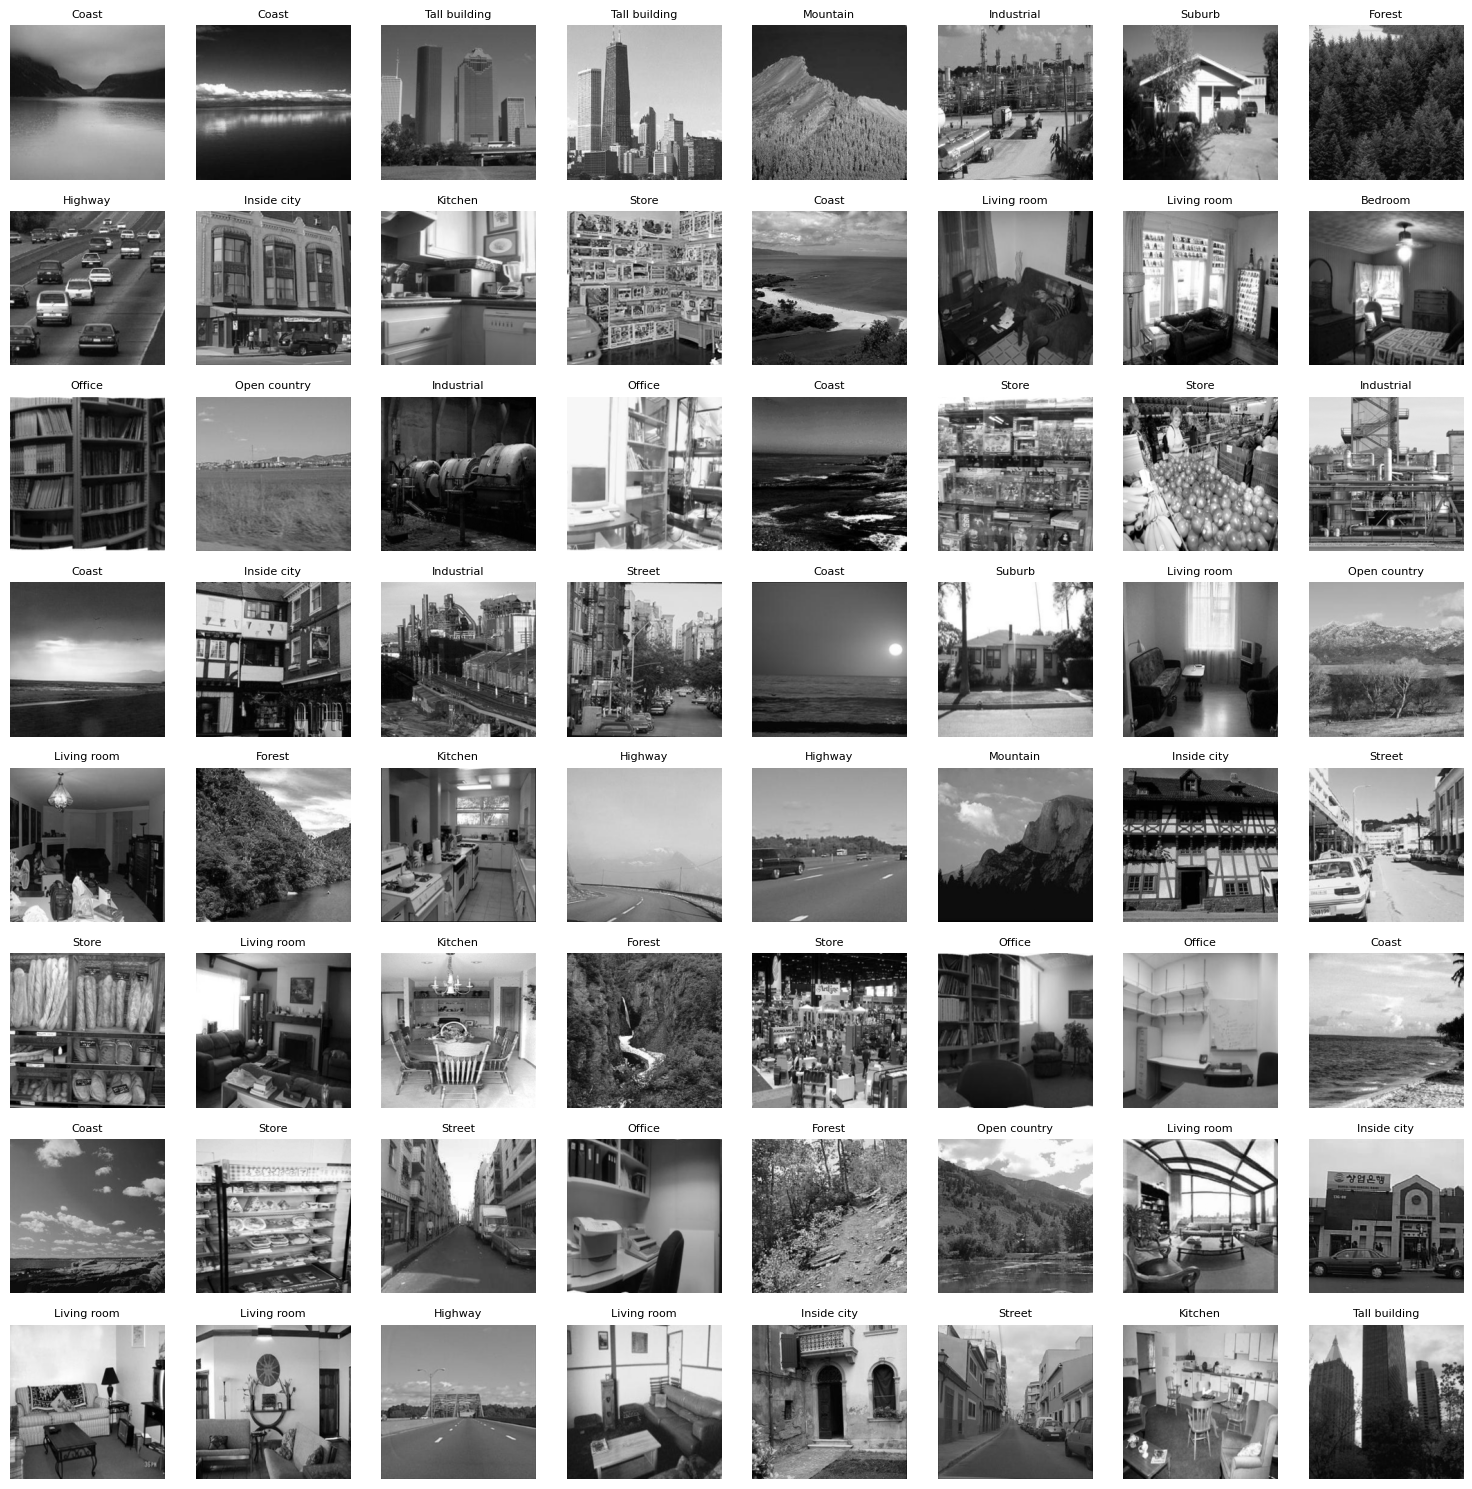

In [10]:
# Obtener 8x8 imágenes aleatorias
random_indices = np.random.choice(len(valid_loader.dataset), size=64, replace=False)
images = [valid_loader.dataset[i][0] for i in random_indices]
classes = [valid_loader.dataset[i][1] for i in random_indices]
classnames = train_loader.dataset.classes
titles = [classnames[x] for x in classes]

# Mostrar la cuadrícula de imágenes
show_images_grid(images, titles, rows=8, cols=8)

A priori no se encuentra nada raro en el conjunto de datos:

 + Las imágenes parecen estar en la misma orientación.

 + Todas se encuentran en blanco y negro.

 + No parece haber problemas con el tamaño de imagen especificado.

 + Parecen estar bien etiquetadas.

### Entrenamiento

Se procede a un entrenamiento básico de la red para comprobar que funcione correctamente.

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
history = model.train_model(train_loader, valid_loader, optimizer, criterion, epochs=1)

Epoch 1/1 - Train Loss: 2.6377, Train Accuracy: 0.3022
Epoch 1/1 - Validation Loss: 2.5214, Validation Accuracy: 0.4960


Tras esto, se guardan los resultados.

In [12]:
model.save('resnet50-1epoch')

### Predicciones

Por último, se carga el modelo entrenado con sus respectivos pesos y se realiza una predicción, para observar su desempeño.

#### Carga del Modelo

In [13]:
# Load model
model_weights = load_model_weights('resnet50-1epoch')
my_trained_model = CNN(torchvision.models.resnet50(weights='DEFAULT'), num_classes)
my_trained_model.load_state_dict(model_weights)

<All keys matched successfully>

### Resultados

In [14]:
predicted_labels = my_trained_model.predict(valid_loader)

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

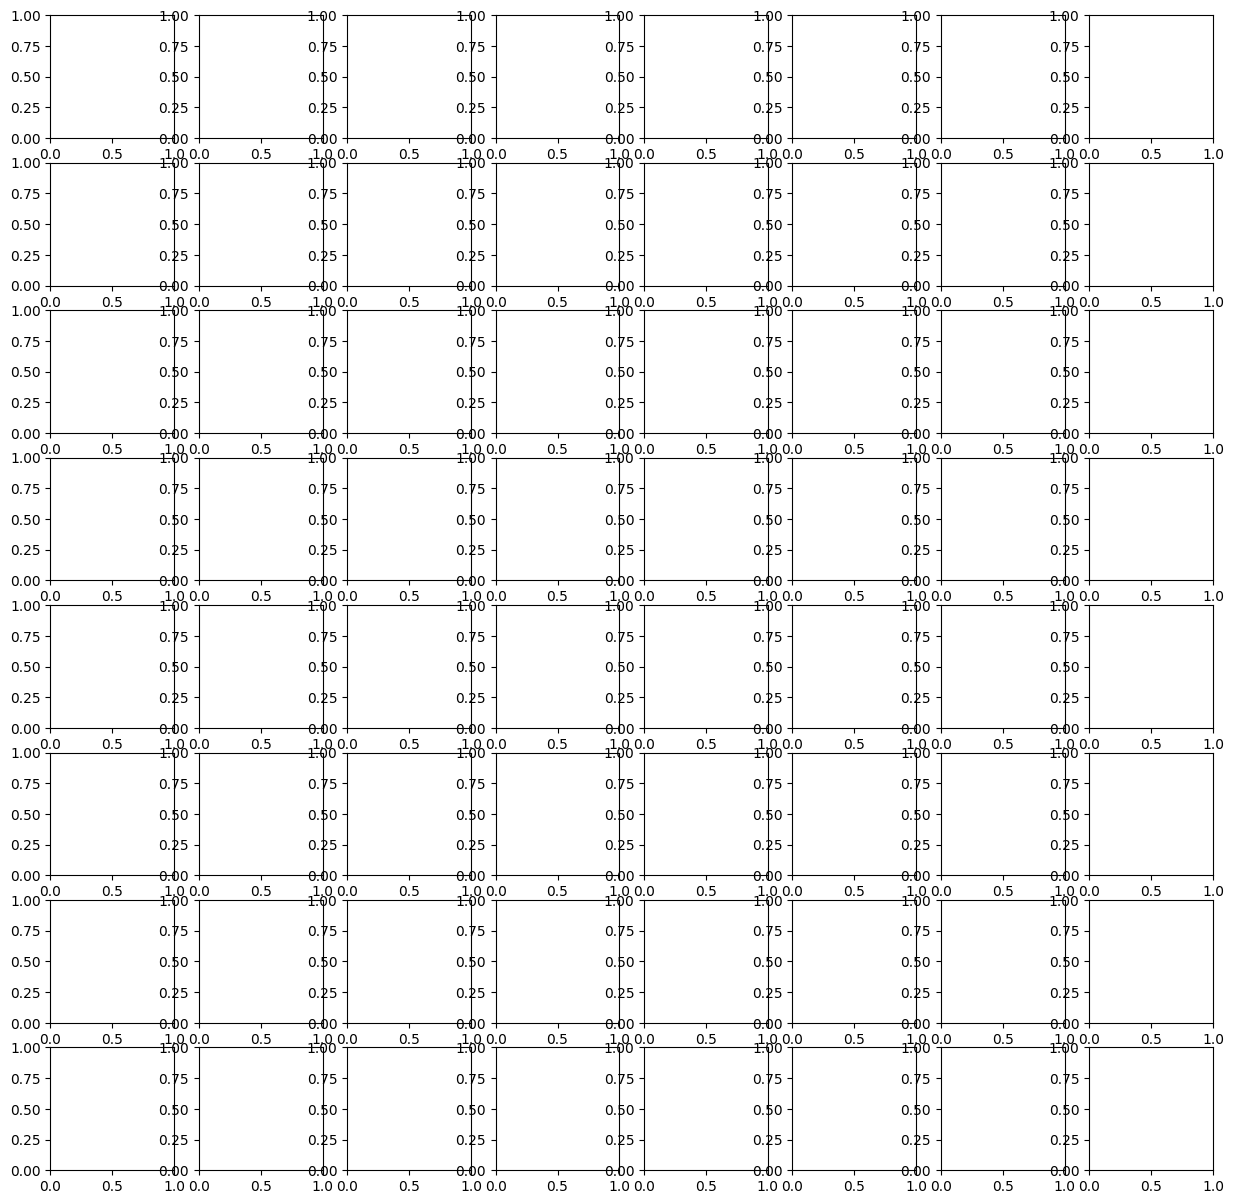

In [17]:
# Obtener 8x8 imágenes aleatorias
random_indices = np.random.choice(len(valid_loader.dataset), size=64, replace=False)
inputs = [valid_loader.dataset[i][0] for i in random_indices]
classes = [valid_loader.dataset[i][1] for i in random_indices]

classnames = train_loader.dataset.classes
titles = [classnames[x] for x in classes]

# Convertir el tensor de salida a las dimensiones adecuadas
out = torchvision.utils.make_grid(inputs, nrow=8)

# Mostrar la cuadrícula de imágenes
show_images_grid(out.permute(1, 2, 0), titles, rows=8, cols=8)

Esta metodología no está mal para un modelo, pero en nuestro caso (en el que se buscan comparar una gran cantidad de modelos diferentes y con muchos parámetros), se recomienda el uso de Weights & Biases para monitorizar las distintas métricas deseadas. Por tanto, hacemos una pequeña prueba.

## 2. Primer Modelo en W&B

In [13]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="ML2-CNN-PROJECT",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "my_trained_model",
    "dataset": "YourDataset",
    "epochs": 4,
    }
)

In [14]:
# Instancia tu modelo de CNN

my_trained_model = CNN(torchvision.models.resnet50(weights='DEFAULT'), num_classes)

# Define el optimizador y la función de pérdida
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

# Entrenamiento del modelo
epochs = 3
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        # Zero gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track training loss
        running_loss += loss.item()

        # Track accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate accuracy and loss
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    # Log metrics to W&B
    wandb.log({"train_loss": train_loss, "train_accuracy": train_accuracy})

# Finaliza el run de W&B
wandb.finish()


train_accuracy,▁██
train_loss,█▂▁
train_accuracy,0.48878
train_loss,2.45971
